# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-S109A Introduction to Data Science 

## Homework 4:  Classification, PCA, and Trees

**Harvard University**<br/>
**Summer 2020**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [2]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [4]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()

from scipy.stats import ttest_ind

<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The dataset is provided in the file `data/genomic_data.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [13 pts]: Data Exploration </b></div>

The first step is to split the observations into an approximate 75-25 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values**. Normalizing genomic data is a fairly standard first step.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.


**1.3** Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.

Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.

**Hint:** You may use any reasonable approach to determine the `best_predictor`, but please use something very simple (whether taught in this class or elsewhere).


**1.4** Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.

<hr> 


### Answers

**The first step is to split the observations into an approximate 75-25 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [5]:
np.random.seed(10)
df = pd.read_csv('data/genomic_data.csv', index_col=0)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.25, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [6]:
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

(752, 7130)
(564, 7129) (188, 7129) (564,) (188,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values.**


In [7]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,...,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,-117.907036,-163.527476,26.835753,210.370847,-248.657677,-406.595313,-28.764782,-190.080423,74.023263,94.750752,...,162.952887,698.676059,2.962852,415.726722,-50.791438,833.447504,329.612463,7.808718,520.229369,-24.088765
std,169.792429,189.691312,205.798155,205.008971,209.564816,258.448200,541.128517,162.728073,175.291394,356.386595,...,164.794952,521.178135,151.324810,580.873231,106.535986,820.213770,370.829412,84.859351,936.957523,72.056218
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-416.206278,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-225.038171,-274.322819,-95.270925,84.245857,-379.511872,-566.993723,-342.364586,-300.978001,-20.279803,-122.958169,...,68.056179,354.959208,-88.764266,96.448742,-105.297264,274.126036,89.320933,-41.845553,-49.150550,-73.781203
50%,-107.412549,-146.993065,20.548933,213.143203,-228.639073,-432.747578,-49.602631,-179.079214,88.038576,102.087963,...,153.844059,679.200114,8.707703,379.423043,-35.816408,776.498538,290.209261,7.337169,460.622697,-25.003950
75%,-6.157261,-43.097489,127.413838,331.513199,-115.153022,-251.990616,324.333687,-73.891345,186.391086,284.218792,...,265.721675,1058.612890,95.688864,718.826611,19.827732,1321.287958,520.922602,62.512588,1109.915839,20.020152
max,516.618491,384.626762,696.983127,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [9]:
X_test = pd.DataFrame(MinMaxScaler().fit(X_train).transform(X_test), columns = X_test.columns, index = X_test.index)
X_train = pd.DataFrame(MinMaxScaler().fit_transform(X_train), columns = X_train.columns, index = X_train.index)

In [8]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,...,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,-117.907036,-163.527476,26.835753,210.370847,-248.657677,-406.595313,-28.764782,-190.080423,74.023263,94.750752,...,162.952887,698.676059,2.962852,415.726722,-50.791438,833.447504,329.612463,7.808718,520.229369,-24.088765
std,169.792429,189.691312,205.798155,205.008971,209.564816,258.448200,541.128517,162.728073,175.291394,356.386595,...,164.794952,521.178135,151.324810,580.873231,106.535986,820.213770,370.829412,84.859351,936.957523,72.056218
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-416.206278,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-225.038171,-274.322819,-95.270925,84.245857,-379.511872,-566.993723,-342.364586,-300.978001,-20.279803,-122.958169,...,68.056179,354.959208,-88.764266,96.448742,-105.297264,274.126036,89.320933,-41.845553,-49.150550,-73.781203
50%,-107.412549,-146.993065,20.548933,213.143203,-228.639073,-432.747578,-49.602631,-179.079214,88.038576,102.087963,...,153.844059,679.200114,8.707703,379.423043,-35.816408,776.498538,290.209261,7.337169,460.622697,-25.003950
75%,-6.157261,-43.097489,127.413838,331.513199,-115.153022,-251.990616,324.333687,-73.891345,186.391086,284.218792,...,265.721675,1058.612890,95.688864,718.826611,19.827732,1321.287958,520.922602,62.512588,1109.915839,20.020152
max,516.618491,384.626762,696.983127,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [9]:
X_test.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,...,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.561738,0.634597,0.501239,0.433427,0.612125,0.380404,0.582946,0.532833,0.631379,0.517483,...,0.519247,0.511867,0.472841,0.395106,0.605775,0.519104,0.389816,0.517771,0.513215,0.453961
std,0.123235,0.134141,0.157874,0.131229,0.136587,0.147493,0.138172,0.156388,0.115769,0.148621,...,0.136079,0.153522,0.159465,0.109187,0.154944,0.129731,0.133707,0.151813,0.152040,0.132519
min,0.222337,0.052362,0.104800,0.105928,0.071105,0.041556,0.156020,0.039091,0.320783,0.206945,...,-0.077168,0.070354,0.092721,0.181925,0.057503,0.149185,0.030233,0.140083,0.074901,0.054844
25%,0.500665,0.562184,0.403885,0.347752,0.529243,0.281566,0.492646,0.422516,0.556706,0.433877,...,0.441398,0.408140,0.361823,0.329071,0.515338,0.435752,0.304626,0.424325,0.430404,0.368946
50%,0.570258,0.645425,0.483037,0.426811,0.627283,0.372691,0.582697,0.546694,0.631572,0.504297,...,0.524073,0.490492,0.474553,0.383808,0.610087,0.512868,0.375929,0.516419,0.493434,0.447750
75%,0.637644,0.714132,0.602182,0.522053,0.689176,0.470946,0.658562,0.633396,0.716083,0.596946,...,0.589623,0.611714,0.566337,0.438184,0.706367,0.599912,0.479222,0.619085,0.593413,0.526402
max,0.914668,0.956050,1.038177,0.809448,1.083614,0.814954,0.935497,0.951292,0.948824,1.135258,...,0.897353,0.956029,0.930731,0.837301,0.975043,0.856707,0.771090,0.905217,1.030505,0.867071


In [10]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a  classification model to such a dataset? Explain in 3 or fewer sentences.**

When there are more features than there are observations, the model will overfit to the training set, but fail to generalize to other data sets. Multicollinearity is likely to be present in the model as well, and matrices may not be invertible, which is a problem for OLS regressions. Ways to compensate for this overabundance of features for potential models is to choose a subset of the predictor variables or to rely on regularization to reduce variance.

**1.3 Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.**

**Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.**

In [11]:
######
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind

ttest_scores1_3 = pd.DataFrame(columns = ['predictor', 'ttest'])
ttest_scores1_3['predictor'] = X_train.columns
for i in range(len(ttest_scores1_3)):
    col = ttest_scores1_3.iloc[i][0]
    ttest_score_val, p_val = ttest_ind(y_train, X_train[X_train.columns[i]], equal_var=False)
    ttest_scores1_3.iloc[i][1] = ttest_score_val
    
ttest_scores1_3
######

,predictor,ttest
0,AFFX-BioB-5_at,-2.90043
1,AFFX-BioB-M_at,-6.53582
2,AFFX-BioB-3_at,-0.599274
3,AFFX-BioC-5_at,2.20951
4,AFFX-BioC-3_at,-5.99498
...,...,...
7124,X83863_at,-0.859423
7125,Z17240_at,5.35509
7126,L49218_f_at,-0.410204
7127,M71243_f_at,-2.3555


In [12]:
best_predictor_tval = abs(ttest_scores1_3['ttest']).max()
best_predictor = ttest_scores1_3[abs(ttest_scores1_3['ttest']) == best_predictor_tval]['predictor'].iloc[0]
best_predictor_ttest = ttest_scores1_3[ttest_scores1_3['predictor']==best_predictor].iloc[0][1]
print('The best predictor is '+ str(best_predictor) + " with a t-test value of "\
     + str(best_predictor_ttest) + ".")

The best predictor is M28825_at with a t-test value of 10.091020834770662.


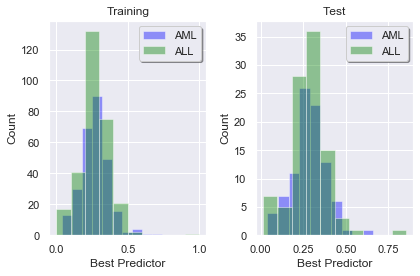

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes.flatten()

ax0.hist(train[train['Cancer_type'] == 1][best_predictor], color ='blue', alpha = 0.4, label = 'AML')
ax0.hist(train[train['Cancer_type'] == 0][best_predictor], color ='green', alpha = 0.4, label = 'ALL')
ax0.set_xlabel('Best Predictor')
ax0.set_ylabel('Count')
ax0.legend(shadow=True, fancybox=True)
ax0.set_title('Training')

ax1.hist(test[test['Cancer_type'] == 1][best_predictor], color ='blue', alpha = 0.4, label = 'AML')
ax1.hist(test[test['Cancer_type'] == 0][best_predictor], color ='green', alpha = 0.4, label = 'ALL')
ax1.set_xlabel('Best Predictor')
ax1.set_ylabel('Count')
ax1.legend(shadow=True, fancybox=True)
ax1.set_title('Test')

fig.tight_layout()
plt.show()

**1.4 Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.**


In [14]:
######
y_pred_train = X_train[best_predictor] >= 0.315
print('The accuracy of the eye-balled model on the training data is', accuracy_score(y_train, y_pred_train))
y_pred_test = X_test[best_predictor] >= 0.315
print('The accuracy of the eye-balled model on the test data is', accuracy_score(y_test, y_pred_test))
######

The accuracy of the eye-balled model on the training data is 0.5088652482269503
The accuracy of the eye-balled model on the test data is 0.5425531914893617


Based on the on the histograms, a threshhold of 0.315 could be reasonable cutoff for differentiating between AML and ALL, with anything below the threshold likely to indicate AML, and anything above the thresshold to be classified as ALL. Since there is a large degree of overlap between the two distributions, there is not a clear threshold between the two cancer types, but the best_predictor model is only a slightly more accurate predictor than a random guess would be (0.5). 

---

<div class='exercise'> <b> Question 2 [20pts]: Logistic Regression Modeling </b> </div>


**2.1** Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. Calculate the training and test classification accuracies of this model. How do these compare to the eye-balled from 1.4? 

*Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

**2.2** Next, fit a multiple logistic regression model with **all** the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?  

**2.3** Print out and interpret the logistic regression coefficients for  `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?

**2.4** Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set. Report the classification accuracy on both the training and testing set.

**2.5** How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.2?


## Answers

**2.1 Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. Calculate the training and test classification accuracies of this model. How do these compare to the eye-balled from 1.4?**

In [15]:
######
model2_1 = LogisticRegression(C=100000, fit_intercept=True).fit(X_train[[best_predictor]], y_train)
yhat2_1 = model2_1.predict(X_test[best_predictor].values.reshape(-1,1))

print("The classification accuracy of the model is " + str(metrics.accuracy_score(y_test, yhat2_1)) + ", and " +\
      "the value of the coefficient is " + str(model2_1.coef_[0][0]) + ".")
######

The classification accuracy of the model is 0.5372340425531915, and the value of the coefficient is 0.3736783930031581.


The classification accuracy of this model is around the same degree of precision as the eyeballed model from 1.4.

**2.2 Next, fit a multiple logistic regression model with *all* the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?**


In [16]:
######
model2_2 = LogisticRegression(C=100000, fit_intercept=True, max_iter=100000).fit(X_train, y_train)
yhat2_2 = model2_2.predict(X_test)

print("The classification accuracy of the model is " + str(metrics.accuracy_score(y_test, yhat2_2)) + ", and " +\
      "the value of the coefficient is " + str(model2_2.coef_[0][0]) + ".")
######

The classification accuracy of the model is 0.7872340425531915, and the value of the coefficient is 1.0633994617453673.


The classification accuracy in this model with all predictor is 79%, rough 25% more accurate than the prior model, with just the best predictor for the model.

**2.3 Print out and interpret the logistic regression coefficients for  `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?**

In [18]:
######
print(model2_1.coef_[0][0])
print(model2_2.coef_[0][X_train.columns.get_loc(best_predictor)])
######

0.3736783930031581
0.16167821974070254


The value of the regression coefficient from the simple logistic model is less than that of the multiple regression model. The coefficient value shrinking in strength when other predictor are added to the model makes sense because it means that the strength of the relationship between the best_predictor variable and the outcome is weakened when other variables are included in the relationship to predict the outcome.

**2.4 Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set. Report the classification accuracy on both the training and testing set.**

In [96]:
######
model2_4 = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=10000)
train_results2_4 = cross_val_score(model2_4, X_train, y_train, cv=KFold(5))
test_results2_4 = cross_val_score(model2_4, X_test, y_test, cv=KFold(5))

print("The classification accuracy for each of the five folds and average accuracy for the training data are respectively", train_results2_4, ' and ',\
      train_results2_4.mean(), " .")
print("The classification accuracy for each of the five folds and average accuracy for the test data are respectively", test_results2_4, ' and ',\
      test_results2_4.mean(), " .")


# ######

The classification accuracy for each of the five folds and average accuracy for the training data are respectively [0.92920354 0.92035398 0.92035398 0.88495575 0.83928571]  and  0.8988305941845764  .
The classification accuracy for each of the five folds and average accuracy for the test data are respectively [0.84210526 0.78947368 0.81578947 0.83783784 0.86486486]  and  0.8300142247510667  .


In [ ]:
ypredict_regular = model2_4.predict(X_train)
ypredict_regular_test = model2.predict(X_test)

print("Training Data Accuracy Score:", metrics.accuracy_score(y_train, ypredict_regular))
print("Testing Data Accuracy Score:", metrics.accuracy_score(y_test, ypredict_regular_test))

**2.5 How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.2?**


In [20]:
######
yhat2_4 = model2_4.fit(X_train, y_train).predict(X_test)
print(metrics.accuracy_score(y_test, yhat2_4))
coefs2_5 = model2_4.fit(X_train, y_train).coef_[0]
count = 0
for i in range(len(coefs2_5)):
    if coefs2_5[i] > 0:
        count += 1
    elif coefs2_5[i] < 0:
        count += 1

print(count, " number of predictors are considered important features in this regularized model.")
######

0.8670212765957447
79  number of predictors are considered important features in this regularized model.


There are far fewer predictors included in this model as important features relative to the full logistic regression model in 2.2. This difference indicates that the model in 2.2 is very likely overfitting to the training set data relative to the test set difference relative to to the regularized model. This hypothesis is confirmed by the greater classification accuracy in the 2.4 model compared to the 2.2 model.

---

<div class='exercise'> <b> Question 3 [10pts]: $k$-NN Classification </b> </div>

**3.1** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`. 

**3.2** Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.2, (ii) the best regularized model from 2.5, and (iii) the best $k$-NN from the previous part. Report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


### Answers

**3.1 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [52]:
######
ks = [1,3,5,7,10,15,20,50,100]
k_dict = {}
model_scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy').mean()
    model_scores.append(scores)
    k_dict[k] = scores

best_k = max(k_dict, key=k_dict.get)
print("The k with the greatest classification accuracy is:", best_k)
######

The k with the greatest classification accuracy is: 3


In [51]:
best_knn = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)
yhat_train3_1 = best_knn.predict(X_train)
yhat_test3_1 = best_knn.predict(X_test)


print("The misclassification rate on the training data is: ", 1-metrics.accuracy_score(y_train, yhat_train3_1))
print("The misclassification rate on the test data is: ", 1-metrics.accuracy_score(y_test, yhat_test3_1))

The misclassification rate on the training data is:  0.08333333333333337
The misclassification rate on the test data is:  0.16489361702127658


**3.2 Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.2, (ii) the best regularized model from 2.5, and (iii) the best $k$-NN from the previous part. what are the  false positive and false negative rates in these 3 models (all in the test set)?  Briefly interpret what you notice.**

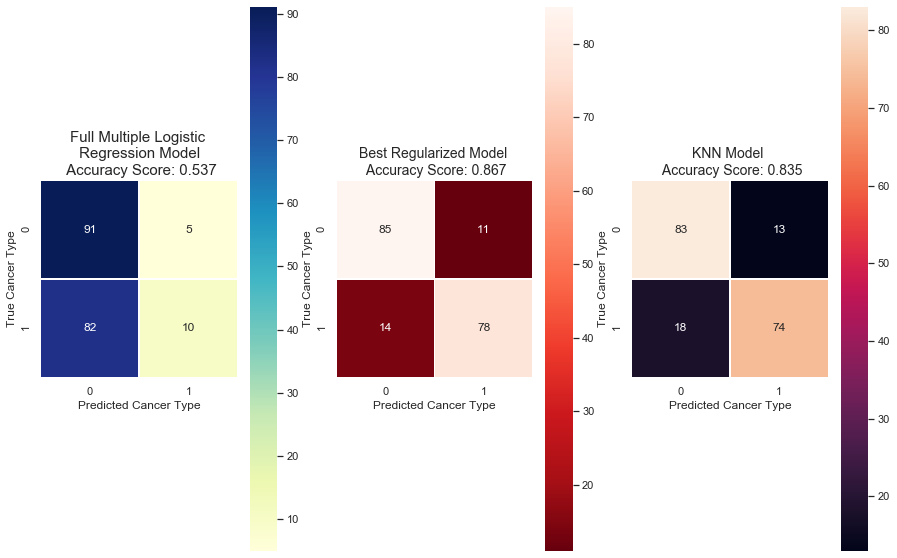

In [50]:
######
multiple_log = metrics.confusion_matrix(y_test, yhat2_1)
best_reg = metrics.confusion_matrix(y_test, model2_4.fit(X_train, y_train).predict(X_test))
best_knn = metrics.confusion_matrix(y_test, yhat_test3_1)

multiple_log_acc = metrics.accuracy_score(y_test, yhat2_1)
best_reg_acc = metrics.accuracy_score(y_test, yhat2_4)
best_knn_acc = metrics.accuracy_score(y_test, yhat_test3_1)

plt.figure(figsize=(15,10))
           
plt.subplot(1, 3, 1)
sns.heatmap(multiple_log, annot=True, square = True, cmap = 'YlGnBu', linewidths=.5);
plt.ylabel('True Cancer Type');
plt.xlabel('Predicted Cancer Type');
plt.title('Full Multiple Logistic \n Regression Model \n Accuracy Score: ' + str(format(round(multiple_log_acc, 3))), size = 15)

plt.subplot(1, 3, 2)
sns.heatmap(best_reg, annot=True, square = True, cmap = 'Reds_r', linewidths=.5);
plt.ylabel('True Cancer Type');
plt.xlabel('Predicted Cancer Type');
plt.title('Best Regularized Model \n Accuracy Score: ' + str(format(round(best_reg_acc, 3))), size = 14)

plt.subplot(1, 3, 3)
sns.heatmap(best_knn, annot=True, square = True, linewidths=.5);
plt.ylabel('True Cancer Type');
plt.xlabel('Predicted Cancer Type');
plt.title('KNN Model \n Accuracy Score: ' + str(format(round(best_knn_acc, 3))), size = 14)

plt.show()
######

The full multiple logistic regression model has a high degree of incorrect AML diagnoses, where the model predicts that a patients has ALL, when in fact they have AML. Unlike the high degree of false negatives (predicting 0 when the true type is 1) shown in the mulitple logistic model, the regularized lasso model and KNN classification model do a much better job of accurately assessing AML diagnoses (predicting 1 accurately). However, the multiple logistic model has slighly fewer false positives (predicting 1 when the true type is 0), inaccurately predicting that a patient has AML when they in fact have ALL less often than the latter two models.

---

#### <div class='exercise'><b> Question 4 [15 pts]: Performing Principal Components Analysis </b></div>

**4.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

*Hint: be sure to standardize before performing PCA.

**4.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different colors and markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**4.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony. 



### Answers

**4.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [49]:
######
pca = PCA().fit(X_train)
x_train_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

print(x_train_pca.shape)
print(x_test_pca.shape)
######

(564, 564)
(188, 564)


The limiting factor is the number of observations from the X_train dataset that the PCA decomposition was fitted to.

**4.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

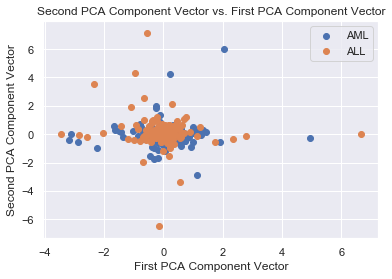

In [25]:
plt.scatter(x_train_pca[0,:][y_train == 1],x_train_pca[1,:][y_train == 1])
plt.scatter(x_train_pca[0,:][y_train == 0],x_train_pca[1,:][y_train == 0])
plt.legend(["AML","ALL"])
plt.xlabel("First PCA Component Vector")
plt.ylabel("Second PCA Component Vector")
plt.title("Second PCA Component Vector vs. First PCA Component Vector")
plt.show()

The top 2 PCA components are the two orthogonal linear combinations of the original predictors, which capture the greatest degree of variance in the dataset. When there is a high dimensional classification problem, PCA allows us to reduce dimensionality by reorganizing the original predictors into a 2D space.

**4.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony. **

Variance explained by the top 2 PCA vectors: 0.1145437357522262
223 PCA vectors are needed so that 90% of the variability in the dataset is explained.


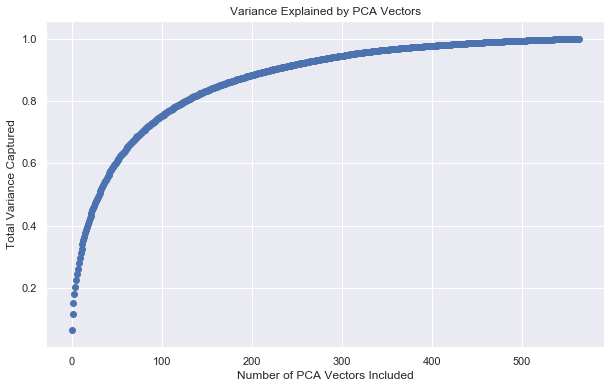

In [48]:
######
print('Variance explained by the top 2 PCA vectors:', pca.explained_variance_ratio_[0] +  pca.explained_variance_ratio_[1])
variance = 0
for i in range(len(pca.explained_variance_ratio_)):
    variance = variance + pca.explained_variance_ratio_[i]
    if variance >= 0.9:
        print(i + 1, 'PCA vectors are needed so that 90% of the variability in the dataset is explained.')
        break

cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(np.cumsum(cum_var))), cum_var)
plt.xlabel("Number of PCA Vectors Included")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA Vectors")
plt.show()
######

As calculated and shown by the graph above, 223 PCA vectors are needed to explain 90% of the variability in the dataset. However, if we want to balance representativeness (of the predictors) with parsimony, we should find the bend or elbow in the graph above, which occurs at the inclusion of approximately 100 PCA vectors. 

---

<div class='exercise'><b> Question 5 [10 pts]: Principal Components Regression (PCR) </b></div>

**5.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?

**5.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `best_predictor` and `Cancer_type`.



### Answers

**5.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?**

In [66]:
######
pcaXdf = pd.DataFrame(x_train_pca)
pcaXdf_test = pd.DataFrame(x_test_pca)
num_components = [2, 100, 223]
pc_df = pd.DataFrame(columns = ['PCA', "Train Accuracy", 'Test Accuracy'])

for n in num_components:
    pcaX_train = pcaXdf.iloc[:, :n]
    pcaX_test = pcaXdf_test.iloc[:, :n]
    logit_pcr = LogisticRegression(C=1000000,solver="lbfgs", max_iter = 10000, fit_intercept=True).fit(pcaX_train,y_train)
    train_accuracy = logit_pcr.score(pcaX_train,y_train)
    test_accuracy = logit_pcr.score(pcaX_test,y_test)
    pc_df = pc_df.append({"PCA": int(n), "Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy}, ignore_index=True)

pc_df
######

,PCA,Train Accuracy,Test Accuracy
0,2.0,0.774823,0.750000
1,100.0,0.914894,0.851064
2,223.0,1.000000,0.771277


The logistric classification accuracy for 2 PCA components yields low training and testing accuracy due to underfitting wherease 223 PCA components overfit the data giving accuracy equals to 1. From our table, we can see that the logistic regression including 100 PCA components has the highest classification accuracy on the test set. This confirms our initial hypothesis that 100 PCA components is the optimal number of vectors to select in order to balance representativeness and parsimony.

**5.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between your `best_predictor` and `Cancer_type`**.

In [76]:
######
num_components = [1, 2, 5, 10, 20, 25, 35, 50, 80, 100, 175, 223, 300]
pc_df = pd.DataFrame(columns = ['PCA', "Train Accuracy", 'Test Accuracy'])
np.random.seed(10)
for n in num_components:
    pca_transformer = PCA(n).fit(X_train)
    X_train_pca = pca_transformer.transform(X_train)
    X_test_pca =  pca_transformer.transform(X_test)
    
    logit3 = LogisticRegressionCV(cv = 5, solver='liblinear', max_iter=10000).fit(X_train_pca, y_train)
    train_results = cross_val_score(logit3, X_train_pca, y_train, cv=KFold(5)).mean()
    test_results = cross_val_score(logit3, X_test_pca, y_test, cv=KFold(5)).mean()
    
    pc_df = pc_df.append({"PCA": int(n), "Train Accuracy": train_results, "Test Accuracy": test_results}, ignore_index=True)

#display table
pc_df
######

,PCA,Train Accuracy,Test Accuracy
0,1.0,0.657728,0.692034
1,2.0,0.771176,0.776529
2,5.0,0.804915,0.787198
3,10.0,0.852781,0.829872
4,20.0,0.893505,0.851209
5,25.0,0.897045,0.851209
6,35.0,0.900601,0.845804
7,50.0,0.897061,0.835135
8,80.0,0.902370,0.840541
9,100.0,0.900601,0.840541


In [102]:
#Eye-balling best model to be PCA 20
pca = PCA(n_components = 20).fit(X_train)
X_train_pca = pca_transformer.transform(X_train)
X_test_pca =  pca_transformer.transform(X_test)
logit20 = LogisticRegressionCV(cv=5,solver='liblinear', max_iter=10000).fit(X_train_pca, y_train)

#add best model's coef to dict
best_model_coef={}

for cf, feature in list(zip(logit20.coef_[0], np.array(X_train.columns))):
    best_model_coef[feature] = cf
    
pcr1=(logit20.coef_*np.transpose(pca.components_[0:1,:])).sum(axis=1)


In [101]:
pcr1[0]

print(best_model_coef[best_predictor])

KeyError: 'M28825_at'

From what I understand we have: log odds = beta_0 + beta_1(PC1) + beta_2(PC2) + … + beta_n(PCn). Then we want to take the linear combination coefficients of the original predictors that make up each of the principle components (via .components_) and then substitute them into that equation where X1, X2, X3 are original predictors. We choose the PCA 20 with the best testing accuracy across the different models. The best PCA model provides a classification accuracy of around 85%, while the regressing on the best predictor alone result in a classification accuracy of 54%. The best predictor alone accounts for only a small fraction of the prediction that is improved upon a random guess rate of 50%. This indicates that additional information is correlated with the best predictor or not useful prediction itself.

Since the number of PCA components used to fit a model is much like the number of predictors used to fit a model, it is clear that only one predictor is insufficient to have a . We want to parsimoniously choose the number of PCA components we use because we can also run into overfitting/underfitting issues when using PCA components. 

<div class='exercise'><b> Question 6 [20 pts]: Tree-Based Methods </b></div>

**6.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 10 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. 

**6.2**  Fit a Bagged Classifier using  `RandomForestClassifier` to the original `X_train` data using 10 as the max depth and 50 trees. Evaluate its accuracy on the test set and assign it to a variable name `bagging_test_score`.

Hint: the number of features to consider when looking for the best split should be equal to the number of features. 

**6.3**  Fit a Random Forest Classifier using  `RandomForestClassifier` to the original `X_train` data using 200 as the max depth and 50 trees. Use number of features to consider when looking for the best split to be the `sqrt(total_number of features)` (not the default). Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.

**6.4** Among all of the decision trees fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**Note:** No tuning was done here to simplify the approach (it should be done in a real life application).

### Answers

**6.1 Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 10 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the test set**. 

In [30]:
######
depths = list(range(1, 11))
train_scores = []
cvmeans = []
cvstds = []
cv_scores = []
for depth in depths:
    dtree = DecisionTreeClassifier(max_depth=depth)
    # Perform 5-fold cross validation and store results
    train_scores.append(dtree.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
######

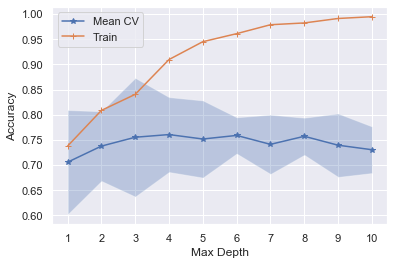

In [31]:
######
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.xticks(depths);
######

In [33]:
best_dtree = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
print('The classification accuracy on the test set is:', best_dtree.score(X_test, y_test))

The classification accuracy on the test set is: 0.7446808510638298


As seen in the graph above, $R^2$ on the training set increases and approaches 1 as max_depth increases. On the other hand $R^2$ on the test set reaches its peak at a max_depth of 4. To balance representativeness of the predictors with parsimony and to prevent overfitting, I would choose a max_depth of 4.

**6.2  Fit a Bagged Classifier using  `RandomForestClassifier` to the original `X_train` data using 10 as the max depth and 50 trees. Evaluate its accuracy on the test set and assign it to a variable name `bagging_test_score`.**

In [41]:
# get original data
np.random.seed(10)
df = pd.read_csv('data/genomic_data.csv', index_col=0)
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.25, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [42]:
######
from sklearn.utils import resample

ntrees = 50
estimators = []
trees = []
y_hats_test = np.zeros((X_test_og.shape[0], ntrees))

for i in range(ntrees):
    simpletree = DecisionTreeClassifier(max_depth=10)
    trees.append(simpletree)
    boot_x, boot_y = resample(X_train_og, y_train)
    estimators = np.append(estimators,simpletree.fit(boot_x, boot_y))
    y_hats_test[:,i] = simpletree.predict(X_test_og)
    bagging_test_score = accuracy_score(y_test, simpletree.predict(X_test_og))

print("Accuracy score of the most frequent occurence in the trees:", bagging_test_score)
######

Accuracy score of the most frequent occurence in the trees: 0.723404255319149


**6.3  Fit a Random Forest Classifier using  `RandomForestClassifier` to the original `X_train` data using 200 as the max depth and 50 trees. Use number of features to consider when looking for the best split to be the `sqrt(total_number of features)` (not the default). Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.**



In [43]:
######
np.random.seed(40)
rf6_3 = RandomForestClassifier(n_estimators=50, max_depth=200, max_features='sqrt').fit(X_train_og, y_train)
random_forest_test_score = accuracy_score(y_test,rf6_3.predict(X_test_og))
random_forest_test_score
############

0.851063829787234

**6.4 Among all of the decision trees fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?**

In [44]:
######
print('Times is each feature used as the top/first node in Bagged Trees:')
first_node_boot = []
for tree in trees:
    first_node_boot.append(tree.tree_.feature[0])
x = np.array(first_node_boot) 
distinct_nodes = np.unique(x)
for dist in distinct_nodes:
    print(dist,' -  ', first_node_boot.count(dist), 'times')

print('Times is each feature used as the top/first node in Random Forest:')
first_node_rf = []
for tree in rf6_3.estimators_:
    first_node_rf.append(tree.tree_.feature[0])
x = np.array(first_node_rf) 
distinct_nodes = np.unique(x)
for dist in distinct_nodes:
    print(dist,' -  ', first_node_rf.count(dist), 'times')
######

Times is each feature used as the top/first node in Bagged Trees:
2287  -   34 times
3319  -   2 times
4365  -   2 times
4846  -   9 times
6538  -   1 times
6854  -   2 times
Times is each feature used as the top/first node in Random Forest:
247  -   1 times
342  -   1 times
460  -   1 times
657  -   1 times
696  -   1 times
757  -   1 times
1092  -   1 times
1124  -   1 times
1295  -   1 times
1597  -   1 times
1778  -   2 times
1833  -   2 times
2000  -   1 times
2355  -   1 times
2362  -   1 times
2525  -   1 times
2610  -   1 times
2738  -   1 times
2994  -   1 times
3013  -   1 times
3251  -   1 times
3319  -   1 times
3630  -   1 times
3673  -   1 times
3961  -   1 times
4095  -   1 times
4195  -   1 times
4225  -   1 times
4264  -   1 times
4342  -   1 times
4376  -   1 times
4810  -   1 times
4858  -   1 times
5335  -   1 times
5505  -   1 times
5509  -   1 times
5513  -   1 times
5682  -   1 times
5771  -   1 times
5793  -   1 times
5983  -   1 times
6040  -   1 times
6048  - 

The above tables illustrate how often features were selected as the top/first node was twice among the 50 trees for the bagged classifier versus the random tree classifier. For the bagged decision trees, nodes 2287 and 4846 were selected 34 and 13 times respectively, while for random forest decision trees, the most a node was selected is 2 times. This distinction occurs because random forests randomly select a subset of features as nodes. As a result, each individual decision tree produced by random forest is more likely to be independent of each other compared to regular bagging. Due to this difference, random forests usually produce more accurate predictions in addition to being faster than bagging (since each random forest decision tree only learns from a subset of predictors).

<div class='exercise'><b> Question 7 [12 pts]: Evaluating Classifiers </b></div>

**7.1**: Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**7.2** Evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models using AUC.  That is calculate AUC for the following models:
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)
- the best tree-based model (question 6)

For the model with the best AUC, plot the ROC. Briefly interpret your plot.

**7.3** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

### Answers

**7.1 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

ROC is a probability curve, and Area-under-the-ROC-Curve (AUC) represents how capable a model is of accurately differentiating between the outcome classes. For instance,  Therefore, if the AUC is 1, the model perfectly distinguishes between classes, with a good measure of separability, and if the AUC is 0, the model does a poor job of differentiating between outcome classes. 

**7.2 use AUC to evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models.  That is calculate AUC for the following models:**
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)
- the best tree-based model (question 6)**

**For the model with the best AUC, plot the ROC. Briefly interpret your plot.**



In [53]:
######
from sklearn.metrics import roc_curve, auc

pca_transformer10 = PCA(10).fit(X_train_og)
X_train_pca10 = pca_transformer.transform(X_train_og)
X_test_pca10 =  pca_transformer.transform(X_test_og)
lr10 = LogisticRegression(C=1000000, solver='lbfgs', multi_class='ovr', max_iter=10000).fit(X_train_pca10, y_train)

fpr2, tpr2, thresholds2 = roc_curve(y_test, model2_4.predict_proba(X_test_og)[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, best_knn.predict_proba(X_test_og)[:,1])
fpr5, tpr5, thresholds5 = roc_curve(y_test, lr10.predict_proba(X_test_pca10)[:,1])
fpr6, tpr6, thresholds6 = roc_curve(y_test, rf6_3.predict_proba(X_test_og)[:,1])

print('Misclassification for best logistic regression model:', 1-auc(fpr2,tpr2))
print('Misclassification for best  𝑘 -NN model:', 1-auc(fpr3,tpr3))
print('Misclassification for best PCR model:', 1-auc(fpr5,tpr5))
print('Misclassification for best tree-based model:', 1-auc(fpr6,tpr6))
######


Misclassification for best logistic regression model: 0.21229619565217395
Misclassification for best  𝑘 -NN model: 0.1493999094202898
Misclassification for best PCR model: 0.1675158514492754
Misclassification for best tree-based model: 0.13807744565217395


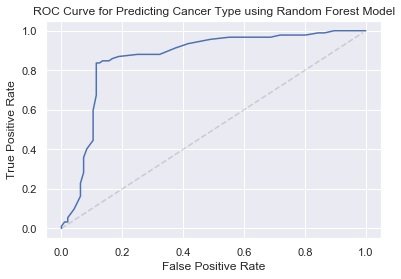

In [57]:
x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr6,tpr6,label="Random Forest Model")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Predicting Cancer Type using Random Forest Model")
plt.show()

*We can see that at the corner, TPR is about 0.85 and FPR is about 0.12. From this point onward, increasing TPR slightly would result in a high increase in the the False Positive Rate and decreaing FPR results in a high decrease in TPR predicted by our model.*

**7.3 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*



**Additional Information**

Acute Lymphoblastic Leukemia (ALL):
- About 98% of children with ALL go into remission within weeks after starting treatment.
- About 90% of those children can be cured. Patients are considered cured after 10 years in remission.

Acute Myeloid Leukemia (AML):
- In general, children with AML are seen as lower risk than adults. 
- Around 85 to 90 percent of children with AML will go into remission after induction, according to the American Cancer Society. AML will return in some cases.  
- The five-year-survival-rate for children with AML is 60 to 70 percent.

<hr style="height:2pt">